In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 5.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import BinaryJaccardIndex
#
import PIL
from PIL import Image
#
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Datos


In [3]:
# creating our own Dataset
class Fish_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)

    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)

        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)

            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img

        return img, mask

In [44]:
transform_data = T.Compose([
                T.Resize([640, 480]),
                T.ToTensor()] )

In [ ]:
train_fish = '/content/drive/MyDrive/Unet/image/480x640_train_fish'             #458 imagenes-Pez          Carpeta con datos de entrenamiento para la red neuronal.
train_fish_fil = '/content/drive/MyDrive/Unet/image/480x640_train_fishCLAHE'    #458 imagenes-PezCLAHE     Carpeta con datos preprocesados para el entrenamiento de la red neuronal.
train_mask = '/content/drive/MyDrive/Unet/image/480x640_train_mask_bin1'        #458 imagnes-Mascaras      Carpeta con las mascaras ideales para el entrenamiento de la red neuronal.

test_fish = '/content/drive/MyDrive/Unet/image/480x640_test_fish'               #78 imagenes-Pez           Carpeta con las imagenes con las cuales se pondra a prueba la red neuronal.
test_fish_fil = '/content/drive/MyDrive/Unet/image/480x640_test_fishCLAHE'      #78 imagenes-CLAHE         Carpeta con las imaganes filtradas con las cuales se pondrá a prueba la red neuronal.

In [ ]:
full_dataset = Fish_Dataset(train_fish_fil,
                           train_mask,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

Iniciar datos para métricas

In [13]:
BATCH_SIZE = 16
batch_metric=1

In [ ]:
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Metricas

In [4]:
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)

        plt.axis('Off')
    plt.tight_layout()
    plt.show()

In [5]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)

        return cost/len(loader), float(correct)/total, dice, iou

In [6]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

NameError: name 'train_loader' is not defined

In [ ]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 16):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            if scheduler:
                scheduler.step()

            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()

            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice:.4f}, iou: {iou:.4f}')

#Modelo

In [ ]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [ ]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),

                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)

class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)

class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)

    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)

class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28

        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14

        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)


        return self.last_conv(u4)

#Learning rate

In [ ]:
# define the model and look for learning rate
torch.manual_seed(42)
model = UNET(3, 64, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.5654, lr: 0.0000, acc: 0.3825
cost:0.5694, lr: 0.0000, acc: 0.3798
cost:0.5694, lr: 0.0000, acc: 0.3704
cost:0.5716, lr: 0.0000, acc: 0.3726
cost:0.5681, lr: 0.0000, acc: 0.3768
cost:0.5681, lr: 0.0001, acc: 0.3772
cost:0.5616, lr: 0.0002, acc: 0.3861
cost:0.5608, lr: 0.0005, acc: 0.3894
cost:0.5425, lr: 0.0013, acc: 0.4124
cost:0.4998, lr: 0.0032, acc: 0.4537
cost:0.4203, lr: 0.0077, acc: 0.4720
cost:0.2722, lr: 0.0190, acc: 0.4916
cost:0.0991, lr: 0.0464, acc: 0.4972
cost:0.0556, lr: 0.1136, acc: 0.4971
cost:0.1066, lr: 0.2783, acc: 0.4967
cost:0.1533, lr: 0.6813, acc: 0.4965
cost:0.2226, lr: 1.6681, acc: 0.4967
cost:0.3006, lr: 4.0842, acc: 0.4970
cost:1.1937, lr: 10.0000, acc: 0.4969


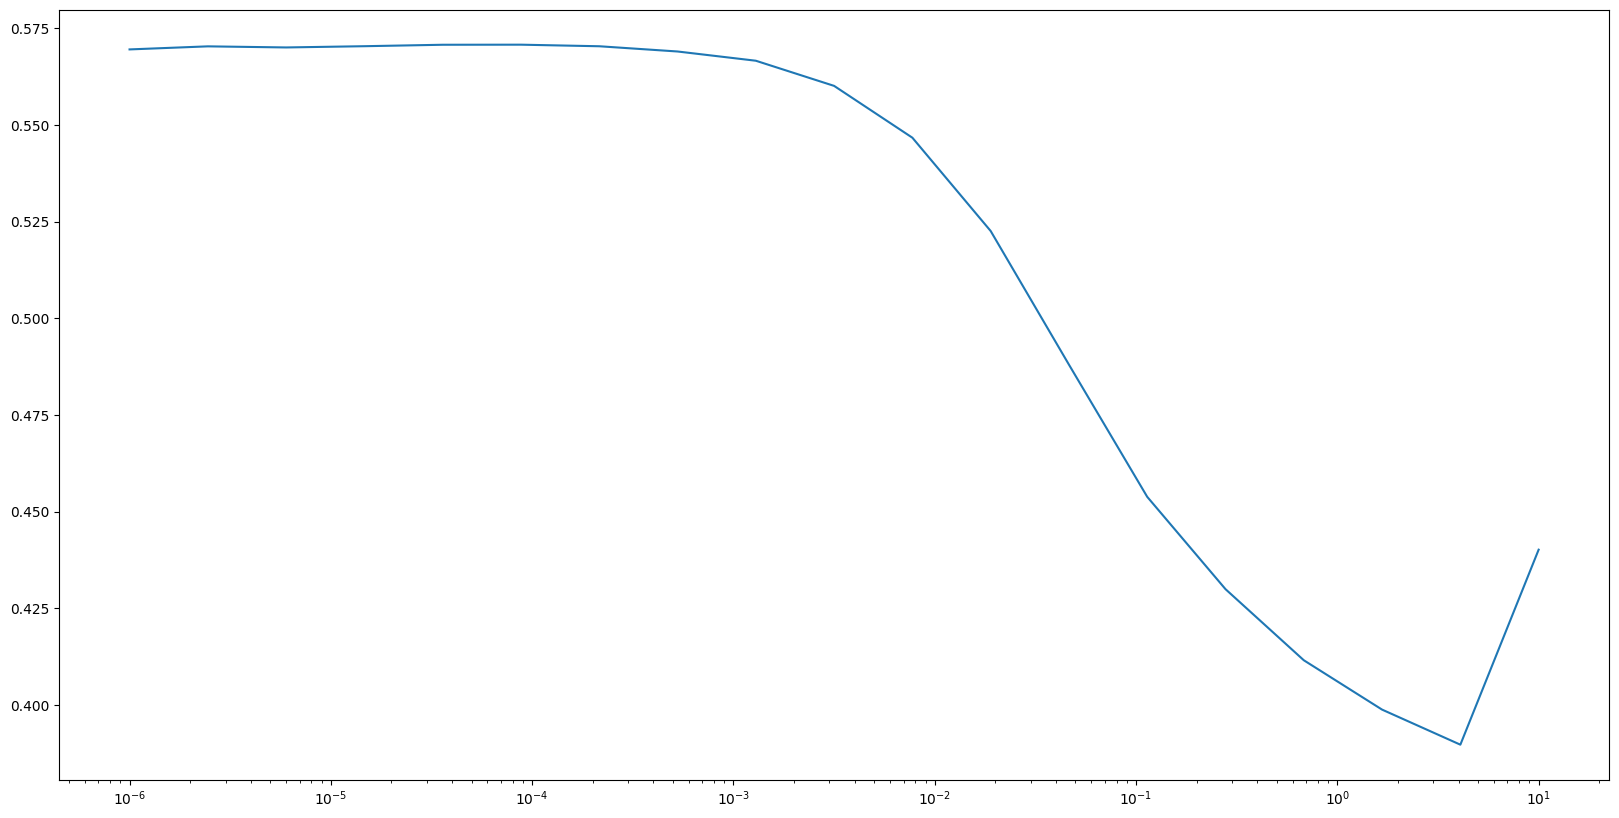

In [ ]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

#Instanciar modelo

In [ ]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 64, 2)
epochs = 100
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

#Entrenamiento

In [ ]:
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, mb: 16, train cost: 0.0806, val cost: 0.0234,train acc: 0.9782, val acc: 0.9940,dice: 0.0000, iou: 0.0000
epoch: 1, mb: 16, train cost: 0.0182, val cost: 0.0171,train acc: 0.9937, val acc: 0.9940,dice: 0.0000, iou: 0.0000
epoch: 2, mb: 16, train cost: 0.0186, val cost: 0.0172,train acc: 0.9937, val acc: 0.9940,dice: 0.0000, iou: 0.0000
epoch: 3, mb: 16, train cost: 0.0170, val cost: 0.0163,train acc: 0.9939, val acc: 0.9940,dice: 0.0000, iou: 0.0000
epoch: 4, mb: 16, train cost: 0.0149, val cost: 0.0140,train acc: 0.9940, val acc: 0.9940,dice: 0.0000, iou: 0.0000
epoch: 5, mb: 16, train cost: 0.0125, val cost: 0.0120,train acc: 0.9941, val acc: 0.9940,dice: 0.0000, iou: 0.0000
epoch: 6, mb: 16, train cost: 0.0115, val cost: 0.0107,train acc: 0.9938, val acc: 0.9940,dice: 0.0000, iou: 0.0000
epoch: 7, mb: 16, train cost: 0.0088, val cost: 0.0084,train acc: 0.9941, val acc: 0.9940,dice: 0.0000, iou: 0.0000
epoch: 8, mb: 16, train cost: 0.0075, val cost: 0.0071,train acc: 0.9939

#Guardar y cargar Modelo

In [ ]:
# Guardar el modelo entrenado y el optimizador
'''torch.save({
    'model_state_dict': model.state_dict(),
    'optimiser_state_dict': optimiser_unet.state_dict(),
    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
    'epoch': epochs
}, '/content/drive/MyDrive/Unet/models/unet_model_fil.pth')
'''


In [ ]:
# Cargar el modelo guardado
checkpoint = torch.load('/content/drive/MyDrive/Unet/models/unet_model_fil.pth')

# Crear una nueva instancia del modelo y del optimizador
model = UNET(3, 64, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

# Cargar los pesos guardados en el modelo
model.load_state_dict(checkpoint['model_state_dict'])

# Cargar el estado del optimizador
optimiser_unet.load_state_dict(checkpoint['optimiser_state_dict'])

# Cargar el scheduler si existe
if checkpoint['scheduler_state_dict']:
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])



<ipython-input-22-1d5f333e765b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Unet/models/unet_model_fil.pth')


#Prueba del Modelo

In [ ]:
test_set = Fish_Dataset(test_fish_fil, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
#print(preds.shape)
#plot_mini_batch(imgs_test, preds.unsqueeze(1))

In [ ]:
# Directorio para guardar las máscaras
output_dir = '/content/drive/MyDrive/Unet/image/predicted_masks_filfix/'
os.makedirs(output_dir, exist_ok=True)

# Itera sobre el DataLoader del conjunto de test
for i, imgs in enumerate(test_loader):
    imgs = imgs.to(device, dtype=torch.float32)
    with torch.no_grad():
        scores = model(imgs)
        preds = torch.argmax(scores, dim=1).float()

    # Mueve las predicciones a la CPU y guarda cada máscara
    preds = preds.cpu()
    batch_size = preds.size(0)  # Tamaño del batch actual
    for j in range(batch_size):
        mask = preds[j].squeeze().numpy() * 255  # Escalar de 0-1 a 0-255
        mask_img = Image.fromarray(mask.astype('uint8'))  # Convertir a imagen
        mask_img.save(os.path.join(output_dir, f'mask_{i * test_loader.batch_size + j}.png'))

print("Máscaras guardadas en", output_dir)


Máscaras guardadas en /content/drive/MyDrive/Unet/image/predicted_masks_filfix/


# Comparacion de metricas

Cargar carpetas

In [49]:
predicted_mask = '/content/drive/MyDrive/Unet/image/predicted_masks_raw'  #78 Imagenes-Predicciones.

predicted_mask_fil = '/content/drive/MyDrive/Unet/image/predicted_masks_fil/'#78 Imagenes Predicciones-Filtro.

pdi_mask_raw = '/content/drive/MyDrive/Unet/image/mascaras_pdi_raw/'

pdi_mask_fix = '/content/drive/MyDrive/Unet/image/mascaras_pdi_fix'                    #78 Imagenes Predicciones-PDI.

test_mask = '/content/drive/MyDrive/Unet/image/480x640_test_mask_bin1'          #78 imagenes-Mascaras-Ideales.

hybrid_mask = '/content/drive/MyDrive/Unet/image/mascaras_hibrido/'#Falta la de Unet postprocesado m#

hybrid_mask_raw ='/content/drive/MyDrive/Unet/image/mascaras_hibrido_raw/'

Crear Dataloader

In [50]:
#Iniciar data con la que se hará la prueba
test_dataset = Fish_Dataset(test_mask,
                           img_transforms=transform_data)
test_mask_loader = DataLoader(test_dataset, batch_size=batch_metric)

In [15]:
#Iniciar data de PDI
mask_pdi_fix = Fish_Dataset(pdi_mask_fix,
                        img_transforms=transform_data)
pdi_loader_fix = DataLoader(mask_pdi_fix, batch_size=batch_metric)

In [40]:
#Iniciar data de PDI
mask_pdi_raw = Fish_Dataset(pdi_mask_raw,
                        img_transforms=transform_data)
pdi_loader_raw = DataLoader(mask_pdi_raw, batch_size=batch_metric)

In [17]:
#Iniciar data predicciones
predicted_data = Fish_Dataset(predicted_mask,
                           img_transforms=transform_data)
predicted_loader = DataLoader(predicted_data, batch_size=batch_metric)

In [18]:
#Iniciar data predicciones con filtros
predicted_data_fil = Fish_Dataset(predicted_mask_fil,
                           img_transforms=transform_data)
predicted_loader_fil = DataLoader(predicted_data_fil, batch_size=batch_metric)

In [19]:
#Iniciar data predicciones con filtros
predicted_data_hybrid = Fish_Dataset(hybrid_mask,
                           img_transforms=transform_data)
predicted_loader_hybrid = DataLoader(predicted_data_hybrid, batch_size=batch_metric)

In [20]:
#Iniciar data predicciones con filtros
predicted_data_hybrid_raw = Fish_Dataset(hybrid_mask_raw,
                           img_transforms=transform_data)
predicted_loader_hybrid_raw = DataLoader(predicted_data_hybrid_raw, batch_size=batch_metric)

In [41]:
#Funcion de IoU
def get_iou(y_true, y_pred,name):
  # Inicializar el métrico de IoU
    metric = BinaryJaccardIndex()

    # Listas para almacenar los resultados
    ious = []

    # Iterar sobre los primeros `num_batches` lotes del DataLoader
    for i, (true_batch, pred_batch) in enumerate(zip(y_true, y_pred)):
        true_images = true_batch.squeeze()
        pred_masks = pred_batch.squeeze()

        # Calcular IoU
        iou = metric(true_images, pred_masks)
        ious.append(iou.item())  # Guardar el valor de IoU como un número

        print(f"IoU de la segmentación {i}: {iou.item()}")


    # Mostrar resultados generales
    promedio_iou = sum(ious) / len(ious)
    print(f"Promedio de IoU: {promedio_iou}")
    print(f'el valor maximo: {max(ious)}, el valor minimo: {min(ious)}')
    print(f'La varianza es : {np.var(ious)}')
    # Plotear el IoU
    fig, ax = plt.subplots()
    ax.plot(range(len(ious)), ious, label='IoU por imagen')
    plt.xlim(0,77)
    plt.ylim(0,1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    ax.axhline(y=promedio_iou, color='r', linestyle='--', label='Promedio')
    ax.set_xlabel('Imagen')
    ax.set_ylabel('IoU')
    ax.legend()
    plt.show()
    #fig.savefig(f'/content/drive/MyDrive/Unet/image/Graficos/{name}_plot.svg')

IoU de la segmentación 0: 0.8537893891334534
IoU de la segmentación 1: 0.8608442544937134
IoU de la segmentación 2: 0.9018669128417969
IoU de la segmentación 3: 0.9176424145698547
IoU de la segmentación 4: 0.5445283651351929
IoU de la segmentación 5: 0.907860279083252
IoU de la segmentación 6: 0.34537726640701294
IoU de la segmentación 7: 0.29213982820510864
IoU de la segmentación 8: 0.8144552111625671
IoU de la segmentación 9: 0.9454680681228638
IoU de la segmentación 10: 0.2669871151447296
IoU de la segmentación 11: 0.26863813400268555
IoU de la segmentación 12: 0.9096385836601257
IoU de la segmentación 13: 0.012437811121344566
IoU de la segmentación 14: 0.0
IoU de la segmentación 15: 0.7351351380348206
IoU de la segmentación 16: 0.9153184294700623
IoU de la segmentación 17: 0.7567706108093262
IoU de la segmentación 18: 0.8564509153366089
IoU de la segmentación 19: 0.8893085718154907
IoU de la segmentación 20: 0.9059457182884216
IoU de la segmentación 21: 0.9174463152885437
IoU de la

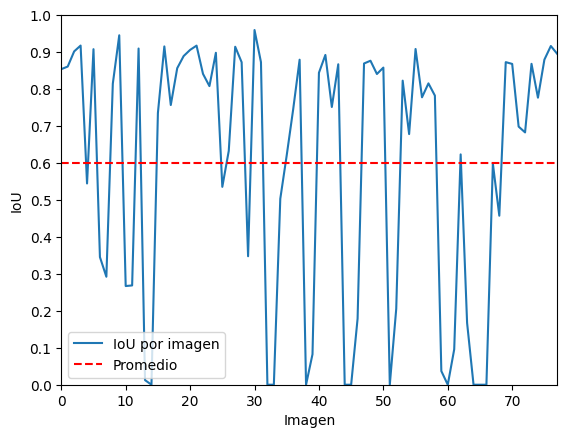

In [51]:
#Comparacion entre PDI RAW e Ideales
get_iou(pdi_loader_raw,test_mask_loader,'pdiraw_ideal')

IoU de la segmentación 0: 0.880835771560669
IoU de la segmentación 1: 0.8620594143867493
IoU de la segmentación 2: 0.8944482803344727
IoU de la segmentación 3: 0.9140774607658386
IoU de la segmentación 4: 0.8456289172172546
IoU de la segmentación 5: 0.911264955997467
IoU de la segmentación 6: 0.9092762470245361
IoU de la segmentación 7: 0.6882814168930054
IoU de la segmentación 8: 0.7798076868057251
IoU de la segmentación 9: 0.929924488067627
IoU de la segmentación 10: 0.3124317228794098
IoU de la segmentación 11: 0.6752758622169495
IoU de la segmentación 12: 0.8814380764961243
IoU de la segmentación 13: 0.6716049313545227
IoU de la segmentación 14: 0.8370750546455383
IoU de la segmentación 15: 0.8170425891876221
IoU de la segmentación 16: 0.9008398056030273
IoU de la segmentación 17: 0.8784179091453552
IoU de la segmentación 18: 0.8230233788490295
IoU de la segmentación 19: 0.9122953414916992
IoU de la segmentación 20: 0.8753888010978699
IoU de la segmentación 21: 0.9338462948799133
I

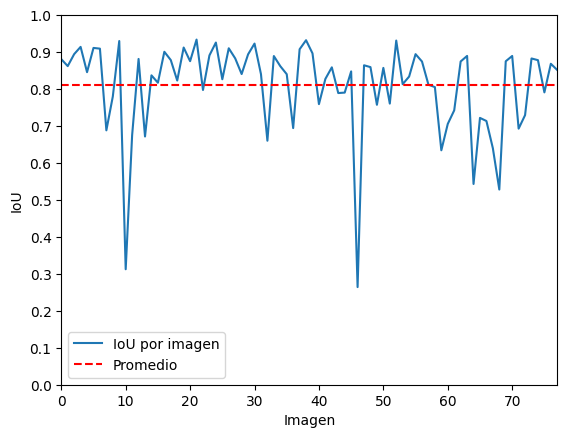

In [24]:
#Comparacion entre PDI e Ideales
get_iou(pdi_loader_fix, test_mask_loader,'pdifix_ideal')

IoU de la segmentación 0: 0.9014319181442261
IoU de la segmentación 1: 0.9518321752548218
IoU de la segmentación 2: 0.9223990440368652
IoU de la segmentación 3: 0.946232259273529
IoU de la segmentación 4: 0.9572135210037231
IoU de la segmentación 5: 0.9575170874595642
IoU de la segmentación 6: 0.9198088049888611
IoU de la segmentación 7: 0.7750511169433594
IoU de la segmentación 8: 0.8757961988449097
IoU de la segmentación 9: 0.850344181060791
IoU de la segmentación 10: 0.954100489616394
IoU de la segmentación 11: 0.9615125060081482
IoU de la segmentación 12: 0.966802179813385
IoU de la segmentación 13: 0.8486352562904358
IoU de la segmentación 14: 0.7133333086967468
IoU de la segmentación 15: 0.7675675749778748
IoU de la segmentación 16: 0.9621602892875671
IoU de la segmentación 17: 0.9572944045066833
IoU de la segmentación 18: 0.9571698904037476
IoU de la segmentación 19: 0.752666175365448
IoU de la segmentación 20: 0.9470638632774353
IoU de la segmentación 21: 0.9349977970123291
IoU

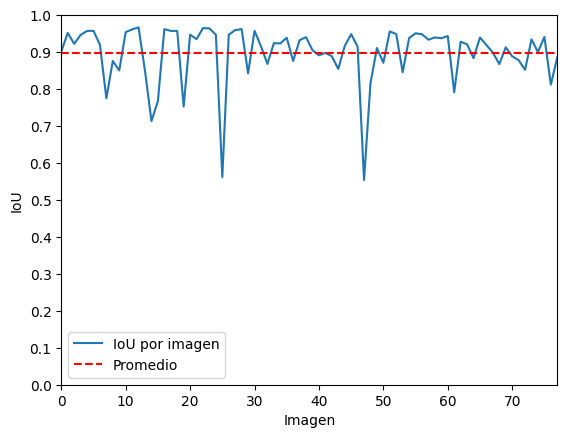

In [25]:
#Comparacion entre Unet e Ideales
get_iou(predicted_loader, test_mask_loader,'unetraw_ideal')

Promedio de IoU: 0.9000709400727198
el valor maximo: 0.968101441860199, el valor minimo: 0.45457756519317627
La varianza es : 0.00730063293264444


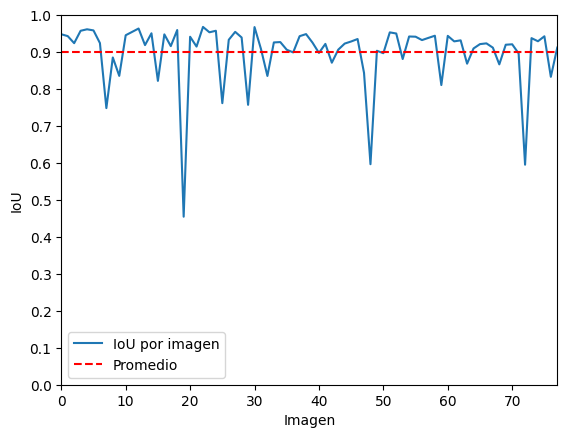

In [ ]:
#Comparacion entre Unet/fil e Ideales
get_iou(predicted_loader_fil, test_mask_loader,'unetfil_ideal')

IoU de la segmentación 0: 0.9482415318489075
IoU de la segmentación 1: 0.9432213306427002
IoU de la segmentación 2: 0.9241311550140381
IoU de la segmentación 3: 0.9576390385627747
IoU de la segmentación 4: 0.9616702198982239
IoU de la segmentación 5: 0.9586449861526489
IoU de la segmentación 6: 0.9243429899215698
IoU de la segmentación 7: 0.7529464960098267
IoU de la segmentación 8: 0.8854389786720276
IoU de la segmentación 9: 0.8630563616752625
IoU de la segmentación 10: 0.9455693364143372
IoU de la segmentación 11: 0.9546523094177246
IoU de la segmentación 12: 0.9637516736984253
IoU de la segmentación 13: 0.9213759303092957
IoU de la segmentación 14: 0.9548248052597046
IoU de la segmentación 15: 0.822102427482605
IoU de la segmentación 16: 0.9479025602340698
IoU de la segmentación 17: 0.9164000153541565
IoU de la segmentación 18: 0.9596773982048035
IoU de la segmentación 19: 0.7534210085868835
IoU de la segmentación 20: 0.9415053725242615
IoU de la segmentación 21: 0.9301734566688538

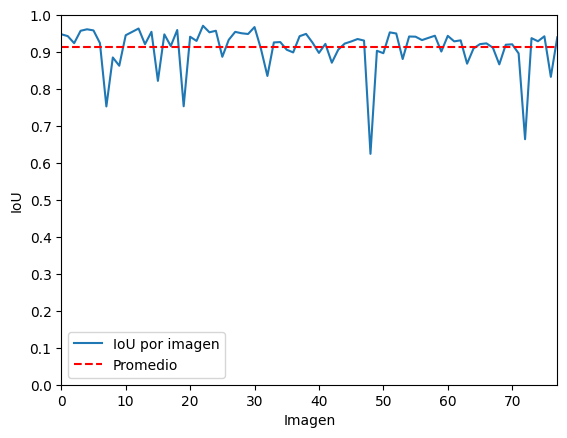

In [26]:
#Comparacion entre Unet/fil e Ideales
get_iou(predicted_loader_hybrid, test_mask_loader,'unet_hybrid')

IoU de la segmentación 0: 0.9014319181442261
IoU de la segmentación 1: 0.9518321752548218
IoU de la segmentación 2: 0.9223990440368652
IoU de la segmentación 3: 0.9478312730789185
IoU de la segmentación 4: 0.9572135210037231
IoU de la segmentación 5: 0.9575170874595642
IoU de la segmentación 6: 0.9198088049888611
IoU de la segmentación 7: 0.7852760553359985
IoU de la segmentación 8: 0.8757961988449097
IoU de la segmentación 9: 0.8897036910057068
IoU de la segmentación 10: 0.954100489616394
IoU de la segmentación 11: 0.9615125060081482
IoU de la segmentación 12: 0.966802179813385
IoU de la segmentación 13: 0.8486352562904358
IoU de la segmentación 14: 0.8142708539962769
IoU de la segmentación 15: 0.7675675749778748
IoU de la segmentación 16: 0.9621602892875671
IoU de la segmentación 17: 0.9572944045066833
IoU de la segmentación 18: 0.9571698904037476
IoU de la segmentación 19: 0.936366856098175
IoU de la segmentación 20: 0.9470638632774353
IoU de la segmentación 21: 0.9354377388954163
I

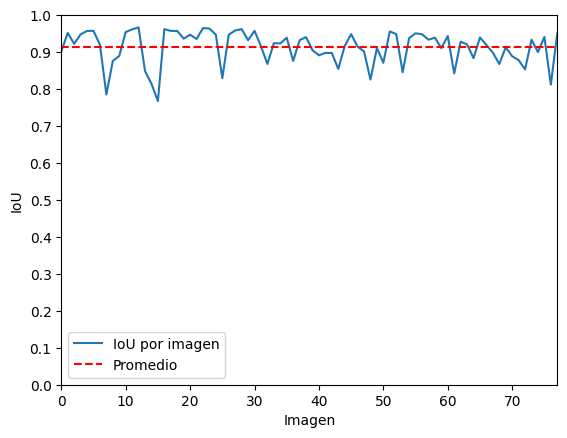

In [27]:
#Comparacion entre Unet/fil e Ideales
get_iou(predicted_loader_hybrid_raw, test_mask_loader,'unet_hybrid_raw')

In [73]:
def get_image_from_dataloader(dataloader, idx):
    data_iter = iter(dataloader)
    for _ in range(idx + 1):  # Avanzar hasta la posición idx
        images = next(data_iter)
    return images

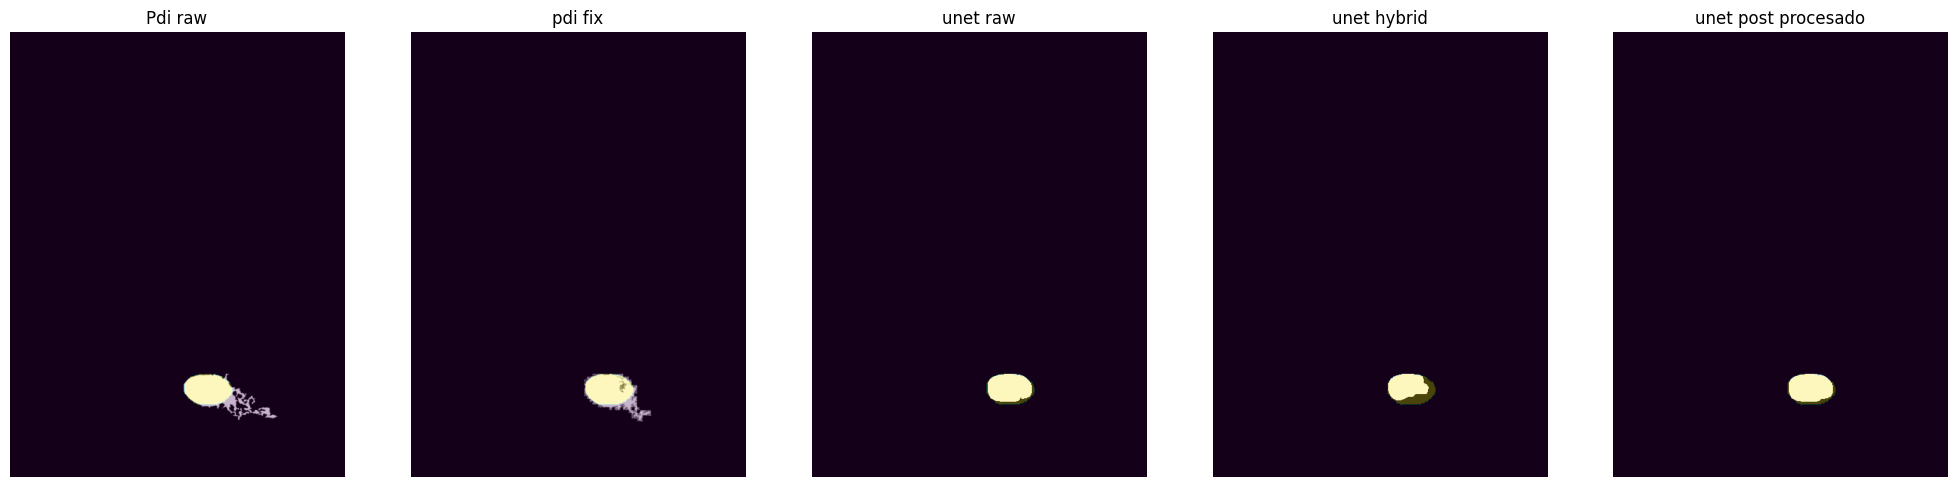

In [93]:
numero = 72
var = 0.3
# Obtener las imágenes de la posición 3 de ambos dataloaders
image1 = get_image_from_dataloader(pdi_loader_raw, numero)
image2 = get_image_from_dataloader(pdi_loader_fix, numero)
image3 = get_image_from_dataloader(predicted_loader, numero)
image4 = get_image_from_dataloader(predicted_loader_hybrid, numero)
image5 = get_image_from_dataloader(predicted_loader_hybrid_raw, numero)
image6 = get_image_from_dataloader(test_mask_loader, numero)

# Mover a CPU y convertir a numpy para plotear
image1 = image1.squeeze().cpu().numpy()
image2 = image2.squeeze().cpu().numpy()
image3 = image3.squeeze().cpu().numpy()
image4 = image4.squeeze().cpu().numpy()
image5 = image5.squeeze().cpu().numpy()
image6 = image6.squeeze().cpu().numpy()

# Crear la figura y mostrar las imágenes
fig, axes = plt.subplots(1, 5, figsize=(25, 15))

axes[0].imshow(image1, cmap='gray')
axes[0].imshow(image6, alpha=var)
axes[0].set_title('Pdi raw')

axes[1].imshow(image2, cmap='gray')
axes[1].imshow(image6, alpha=var)

axes[1].set_title('pdi fix')

axes[2].imshow(image3, cmap='gray')
axes[2].imshow(image6, alpha=var)

axes[2].set_title('unet raw')

axes[3].imshow(image4, cmap='gray')
axes[3].imshow(image6, alpha=var)

axes[3].set_title('unet hybrid')

axes[4].imshow(image5, cmap='gray')
axes[4].imshow(image6, alpha=var)

axes[4].set_title('unet post procesado')


# Quitar los ejes
for ax in axes:
    ax.axis('off')

plt.show()
